# Terror5

# Step 1. Load data
Load csv file in a dataframe, check encoding and low_memory=False because some columns are mix types.
Columns (4,61,62,66,116,117,123) have mixed types.

In [84]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# %pdb

import pandas as pd

gtd = pd.read_csv('gtd_utf.csv', encoding='latin1', low_memory=False)
gtd.columns

Index(['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended',
       'resolution', 'country', 'country_txt', 'region',
       ...
       'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', 'INT_LOG',
       'INT_IDEO', 'INT_MISC', 'INT_ANY', 'related'],
      dtype='object', length=137)

**Check groups bias**

Which group is responsible for the attacks?

In [85]:
from collections import Counter

# Terrorist group name is the target
target = gtd['gname']

gcount = Counter(target)
print('Number of groups = {}'.format(len(gcount)))
g1 = gcount.most_common(1)[0]
print('Be careful with bias, {} = {:.4f}%'.format(g1[0], 100 * g1[1] / target.size))
gcount.most_common(5)

Number of groups = 3290
Be careful with bias, Unknown = 45.8768%


[('Unknown', 71922),
 ('Taliban', 5502),
 ('Shining Path (SL)', 4548),
 ('Farabundo Marti National Liberation Front (FMLN)', 3351),
 ('Islamic State of Iraq and the Levant (ISIL)', 2833)]

# Step 2. Preprocessing

In [86]:
from collections import Counter

threshold = 10
group_count = Counter(gtd['gname'])
groups = [group for group, counter in group_count.items() if counter >= threshold]
len(groups)

527

In [87]:
gtd_clean = gtd[gtd['gname'].isin(groups)]
len(gtd_clean)

150816

### Step 2.1 Remove unknowns

In [88]:
# Remove Unknowns

region2 = gtd_clean[(gtd_clean['region']==2) & (gtd_clean['gname']!='Unknown')]
total_region2 = len(region2)

### Step 2.2 Remove a particular biased group

In [89]:
# Remove a particular group that skews predictions

#region2 = region2[(region2['gname']!='Farabundo Marti National Liberation Front (FMLN)')]
#len(region2)

# Step 3. Naive Bayes Classifier

### Step 3.1 Splitting into Training and Testing sets

In [90]:
from sklearn.model_selection import train_test_split

features_used = ['iyear', 'country']

data_target = region2['gname']
data_features = region2[features_used]

X_train, X_test, Y_train, Y_test = train_test_split(data_features, data_target, test_size=0.30)

train = pd.concat([Y_train, X_train], axis=1)
test = pd.concat([Y_test, X_test], axis=1)

year_counts = X_train['iyear'].value_counts()
total_years = len(year_counts)
year_probabilities = year_counts / total_years

country_counts = X_train['country'].value_counts()
total_country = len(country_counts)
country_probabilities = country_counts / total_country

test_groups = pd.unique(Y_test)

train_groups = pd.unique(Y_train)
train_years = pd.unique(X_train['iyear'])
train_countries = pd.unique(X_train['country'])

train_groups_len = len(train_groups)
train_years_len = len(train_years)
train_countries_len = len(train_countries)

train_groups_year_likelihoods = [(x, y, 0) for x in train_groups for y in train_years]
train_groups_country_likelihoods = [(x, y, 0) for x in train_groups for y in train_countries]

train_groups_year_likelihoods = pd.DataFrame(train_groups_year_likelihoods)
train_groups_country_likelihoods = pd.DataFrame(train_groups_country_likelihoods)

train_groups_year_likelihoods.columns = ['gname', 'year', 'likelihood']
train_groups_country_likelihoods.columns = ['gname', 'country', 'likelihood']

### Step 3.2 Do the Scikit Learn magic

In [150]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

gnb = MultinomialNB()
y_pred = gnb.fit(X_train, Y_train).predict(X_test)

good_predictions = (Y_test == y_pred).sum()
total_predictions = len(Y_test)

print("Good predictions " + str(good_predictions) + " out of " + str(total_predictions))
print
print("Accuracy: " + str((good_predictions/total_predictions)*100) + "%")

Good predictions 1319 out of 1908
Accuracy: 69.1299790356%


### Step 3.3 Plot the Confusion Matrix

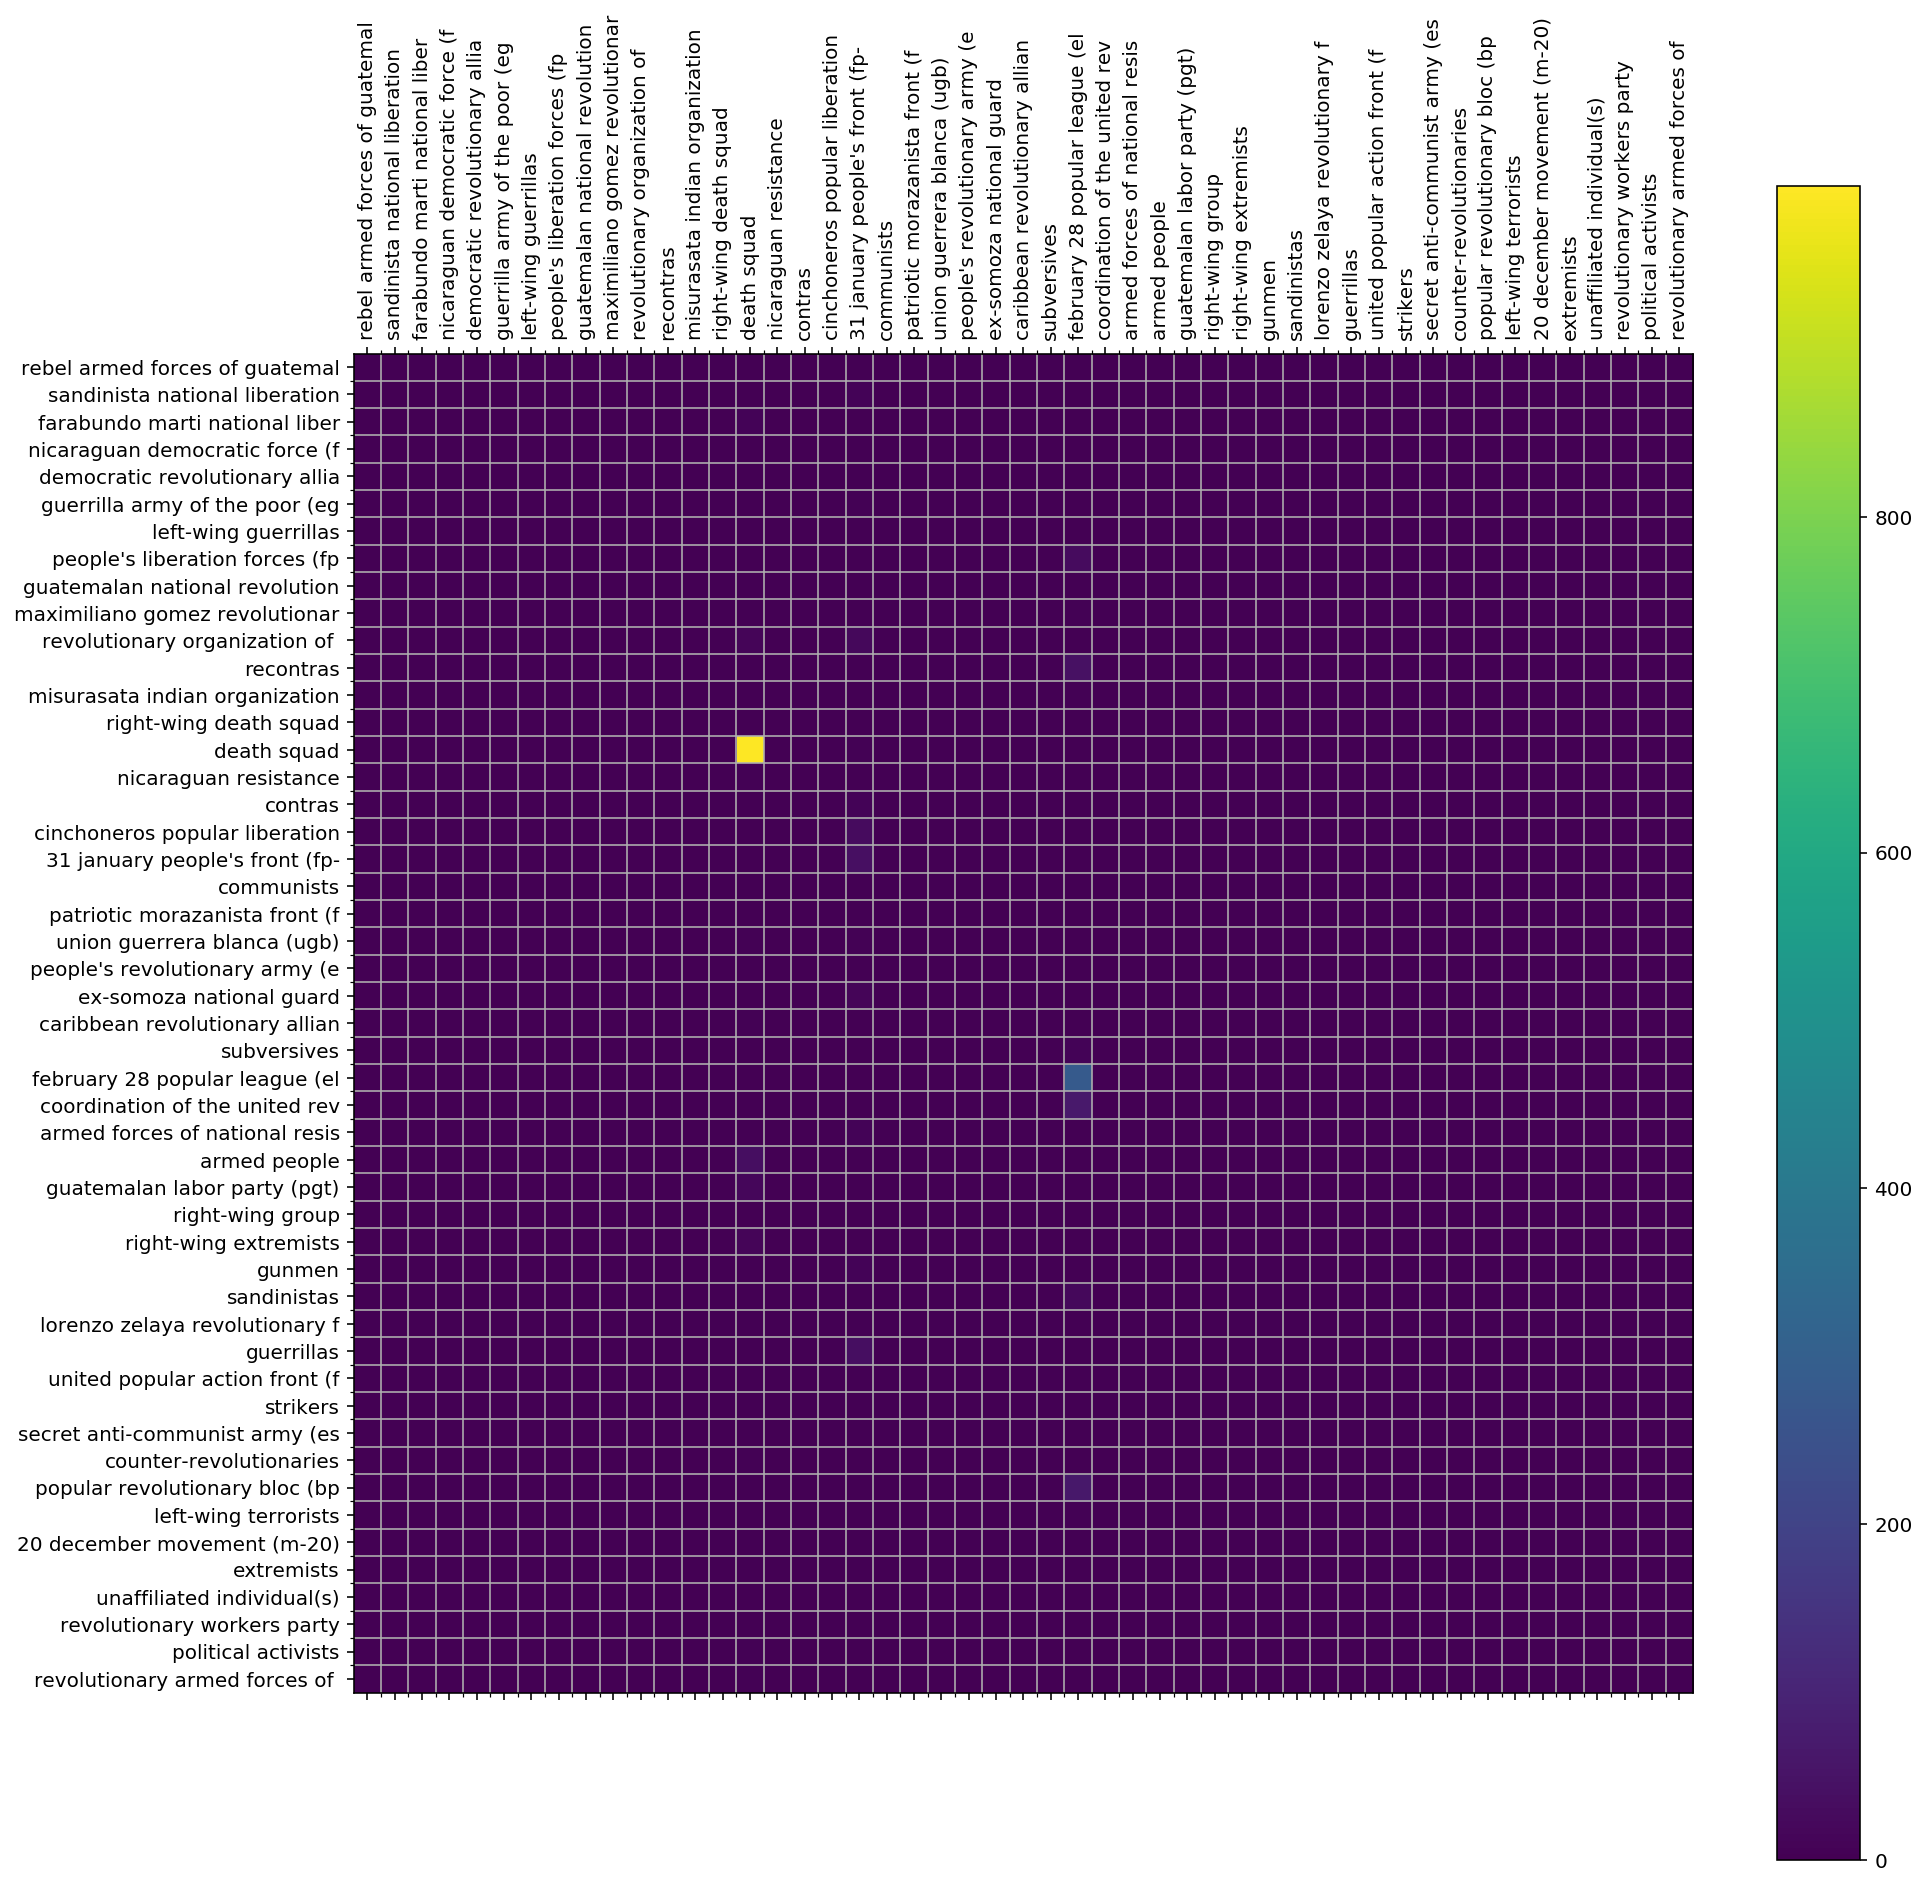

In [151]:
from sklearn.metrics import confusion_matrix

#actual_vs_predicted = [(x, y) for x in Y_test for y in y_pred]
#print(actual_vs_predicted)

confusion_matrix = confusion_matrix(Y_test, y_pred)

#print(test_groups.shape)
#print(confusion_matrix.shape)

class_names = test_groups
class_names = [word[:30].lower() for word in class_names]

#print(class_names)

plt.figure()
plt.rcParams['figure.figsize'] = (15, 15)

plt.matshow(confusion_matrix, interpolation='nearest')
plt.colorbar()

plt.xticks(np.arange(0,len(class_names)), class_names)
plt.yticks(np.arange(0,len(class_names)), class_names)

plt.xticks(rotation=90)

plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')
plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')
plt.grid(which='minor')

plt.show()

In [153]:
print("Test set has " + str(len(Y_test)) + " number of attacks")
print()

for index in range(len(class_names)):
    print(str(confusion_matrix[index][index]) + " instances CORRECTLY PREDICTED as " + class_names[index] + " + in the confusion matrix")

    looking_for_group = class_names[index]

    Y_test2 = [word.lower() for word in Y_test]
    #print("death squad" in Y_test2)
    #print(Y_test2)

    count = 0

    for word in Y_test2:
        if looking_for_group == word:
            #print(word)
            count = count + 1

    print("In reality " + looking_for_group + " is responsible for " + str(count/len(Y_test2)*100) + "% test attacks")
    print()

Test set has 1908 number of attacks

0 instances CORRECTLY PREDICTED as rebel armed forces of guatemal + in the confusion matrix
In reality rebel armed forces of guatemal is responsible for 0.0% test attacks

0 instances CORRECTLY PREDICTED as sandinista national liberation + in the confusion matrix
In reality sandinista national liberation is responsible for 0.0% test attacks

0 instances CORRECTLY PREDICTED as farabundo marti national liber + in the confusion matrix
In reality farabundo marti national liber is responsible for 0.0% test attacks

0 instances CORRECTLY PREDICTED as nicaraguan democratic force (f + in the confusion matrix
In reality nicaraguan democratic force (f is responsible for 0.0% test attacks

0 instances CORRECTLY PREDICTED as democratic revolutionary allia + in the confusion matrix
In reality democratic revolutionary allia is responsible for 0.0% test attacks

0 instances CORRECTLY PREDICTED as guerrilla army of the poor (eg + in the confusion matrix
In reality 